## Uncertainty Quantifications - Monte Carlo Simulations

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. Specifically:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Xocide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

see https://github.com/A-440Hz/ML4SCM/blob/main/Python-PHREEQC%20IO.ipynb for additional example

In [13]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

TDBfile = 'llnl'
outfile = 'output.sel' 
pars    = ['!Hfo_sOUO2+s!', '!Hfo_wOUO2+w!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'

# bounds from table 2 in Mahoney et. al.
lower = [2.116, 0.744, 0.284, 0.18]
upper = [9.586, 5.814, 18.354, 30.78]

# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            return True
        print("error: listed bounds are inconsistent")
        return False
    
    print("error: lists are different lenghts")
    return False

print(verify(lower, upper))


True


#### Generate values from probablilty distributions

*num_iterations* controls how many phreeqc runs are done

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [14]:
num_iterations = 9

# returns a list of random values between lower and upper
def get_random_values(lower, upper):
    values = []
    for i in range(len(lower)):
        values.append(numpy.random.uniform(lower[i], upper[i]))
    return values



# runs num_iterations simulations, assuming initial parameters are set correctly
def MC_sim(num_iterations, lower, upper):
    # return: list of 2-row np arrays for now
    # maybe change to dataframe once I figure out the sorting issue I am having
    # currently assuming simulation# from phreeqc always in correct incremental order
    # I would feel better if I sorted it programatically before graphing
    
    obs_all = []

    for itr in range(num_iterations):
        # generate new values and add to outputoutput
        values = get_random_values(lower, upper)

        writeInput(TDBfile, pars, values)
        os.popen(pqcpath+' input.txt output.txt llnl.txt')
        obs = readOutput(outfile)
        obs_all.append(obs)

    return obs_all
res = MC_sim(num_iterations, lower, upper)
#res

[array([[4.0000e+00, 5.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00,
         9.0000e+00, 1.0000e+01, 1.1000e+01, 1.2000e+01, 1.3000e+01,
         1.4000e+01, 1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01,
         1.9000e+01, 2.0000e+01, 2.1000e+01, 2.2000e+01, 2.3000e+01,
         2.4000e+01, 2.5000e+01, 2.6000e+01, 2.7000e+01, 2.8000e+01,
         2.9000e+01, 3.0000e+01, 3.1000e+01, 3.2000e+01, 3.3000e+01,
         3.4000e+01, 3.5000e+01, 3.6000e+01, 3.7000e+01, 3.8000e+01,
         3.9000e+01, 4.0000e+01, 4.1000e+01, 4.2000e+01, 4.3000e+01,
         4.4000e+01, 4.5000e+01, 4.6000e+01, 4.7000e+01, 4.8000e+01,
         4.9000e+01, 5.0000e+01, 5.1000e+01, 5.2000e+01, 5.3000e+01,
         5.4000e+01, 5.5000e+01, 5.6000e+01, 5.7000e+01, 5.8000e+01,
         5.9000e+01, 6.0000e+01, 6.1000e+01, 6.2000e+01, 6.3000e+01,
         6.4000e+01, 6.5000e+01, 6.6000e+01, 6.7000e+01, 6.8000e+01,
         6.9000e+01, 7.0000e+01, 7.1000e+01, 7.2000e+01, 7.3000e+01,
         7.4000e+01, 7.5000e+01, 7

#### Plotting

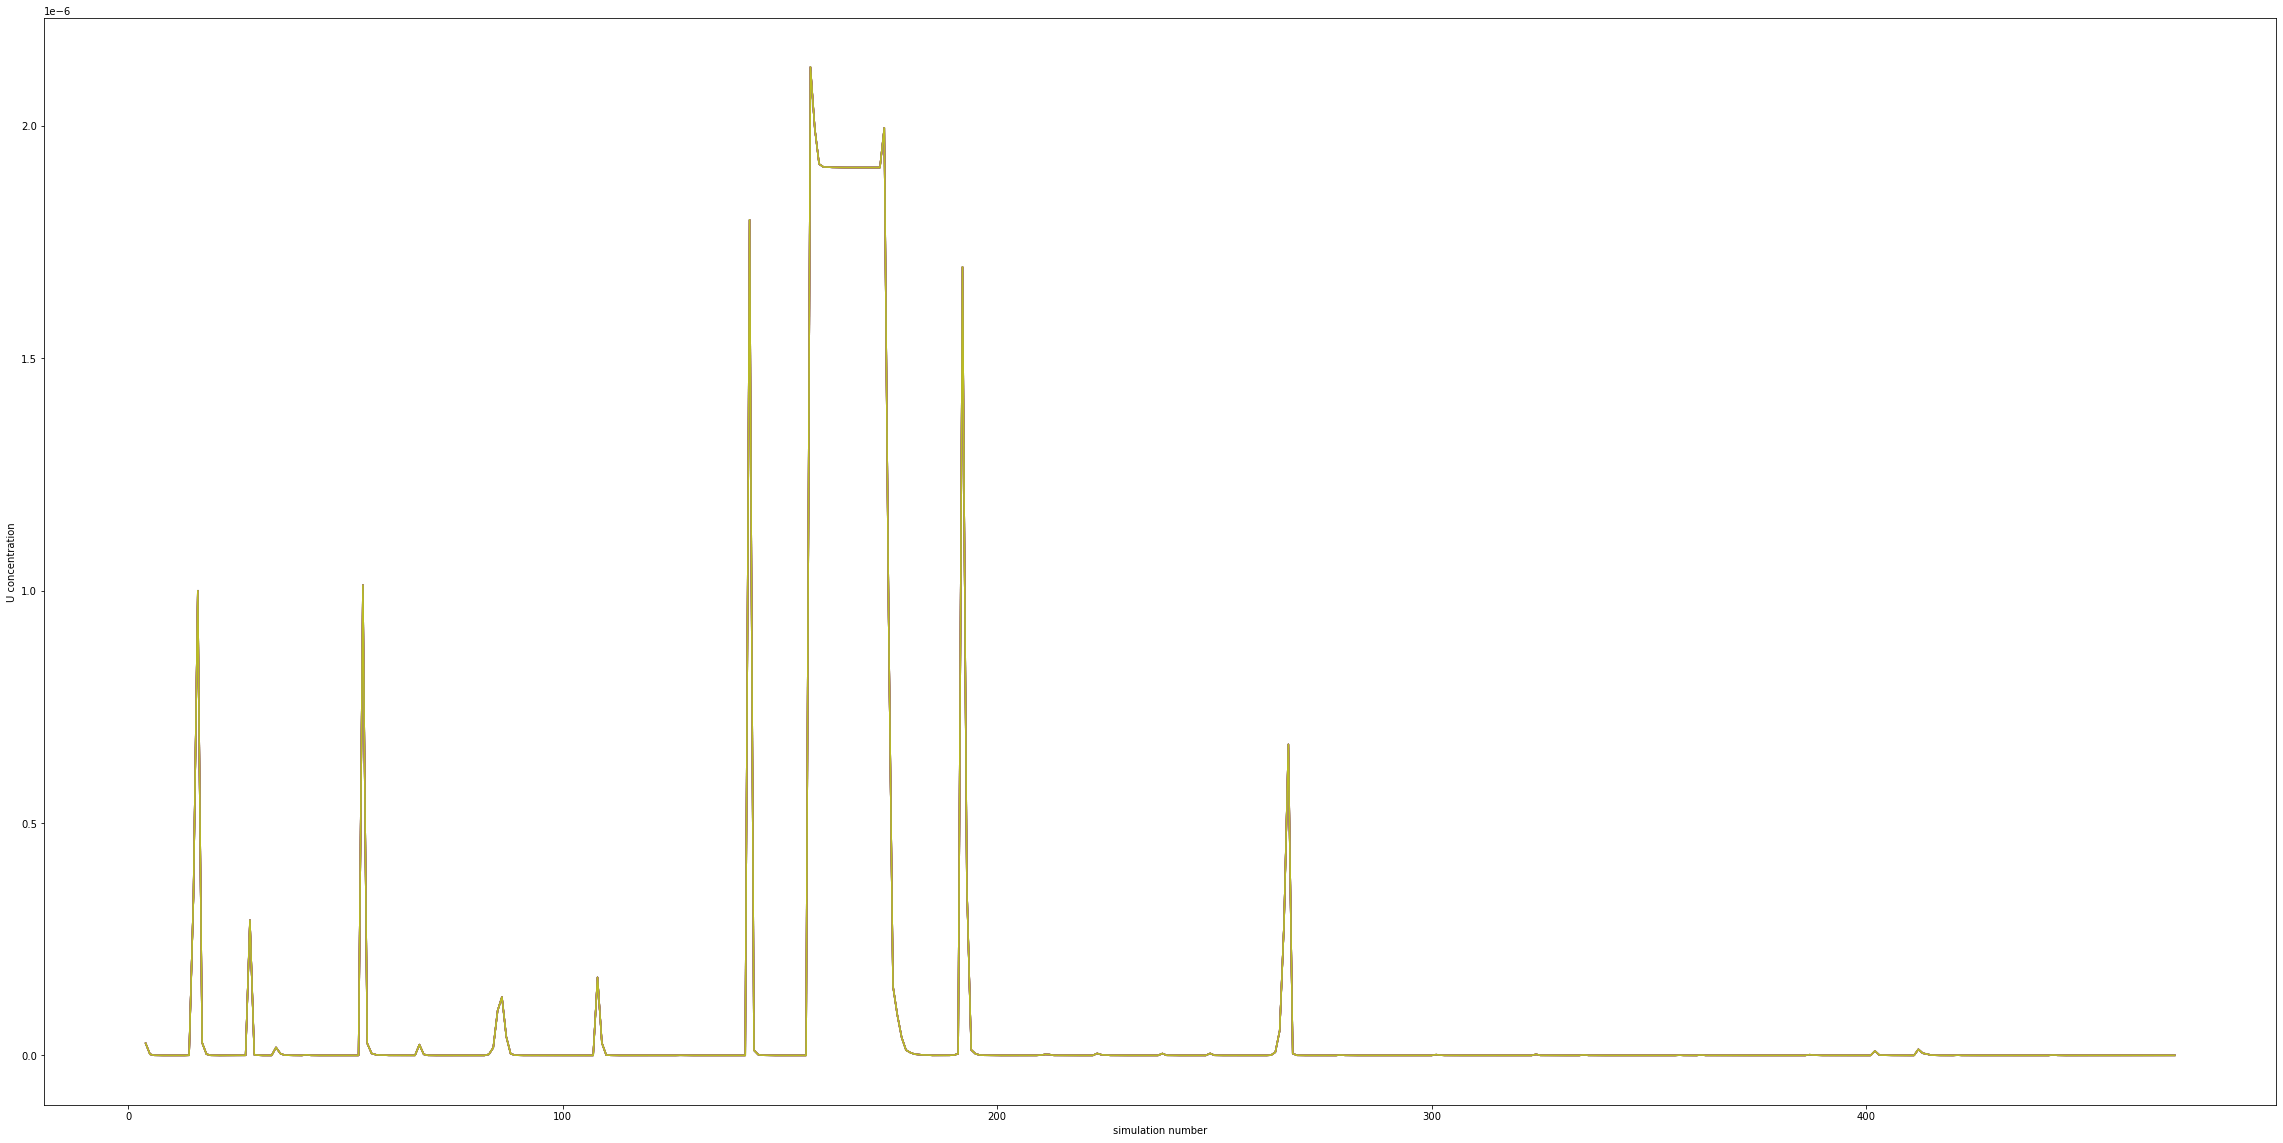

In [36]:
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(20)
plt.xlabel('simulation number')
plt.ylabel('U concentration')
for run in res:

    plt.plot(run[0], run[1])


plt.show()


### Remaining Questions:
---

- readOutput currently generates and overwrites output files each time I run phreeqc. Should I:
    - overlook this for now
    - stop generating/overwriting output files when I just care about the graph
    - generate some other file instead based on the data I get from MC_sim
